In [38]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm import tqdm
from torch.utils.data import random_split
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import pandas as pd
from  visualize_trajectory import make_gif

In [39]:
torch.cuda.is_available()

False

In [40]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [41]:
def getData(path):
    train_file = np.load(path+"/train.npz")
    train_data = train_file['data']
    test_file = np.load(path+"/test_input.npz")
    test_data = test_file['data']
    print(f"Training Data's shape is {train_data.shape} and Test Data's is {test_data.shape}")
    return train_data, test_data

In [42]:
trainData, testData = getData("./data")
trainData.shape, testData.shape

Training Data's shape is (10000, 50, 110, 6) and Test Data's is (2100, 50, 50, 6)


((10000, 50, 110, 6), (2100, 50, 50, 6))

In [43]:
trainData[0,0,0, :], trainData[0,0,54, :], trainData[0,0,109, :]

(array([ 338.59322192, -672.21574762,   -5.32538052,    1.61518358,
           2.84662927,    0.        ]),
 array([ 282.98837762, -655.15099393,  -10.53980359,    3.24089969,
           2.84118644,    0.        ]),
 array([ 227.8980634 , -638.2856791 ,   -4.56724737,    1.36742777,
           2.85071592,    0.        ]))

In [44]:
def center_coordinates(data):
    centered_data = data.copy()
    mean_x = np.zeros(data.shape[0])
    mean_y = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        mean_x[i] = np.mean(data[i, :, :, 0])  
        mean_y[i] = np.mean(data[i, :, :, 1])
        centered_data[i, :, :, 0] -= mean_x[i]
        centered_data[i, :, :, 1] -= mean_y[i]
    return centered_data, mean_x, mean_y

trainData, trainmeanX, trainmeanY = center_coordinates(trainData)
testData, testmeanX, testmeanY = center_coordinates(testData)


In [45]:
trainData[0,0,0, :], trainData[0,0,54, :], trainData[0,0,109, :]

(array([ 252.08744671, -457.50194791,   -5.32538052,    1.61518358,
           2.84662927,    0.        ]),
 array([ 196.48260241, -440.43719422,  -10.53980359,    3.24089969,
           2.84118644,    0.        ]),
 array([ 141.39228819, -423.57187938,   -4.56724737,    1.36742777,
           2.85071592,    0.        ]))

In [46]:
# make_gif(trainData[0], 'index_0_norm')

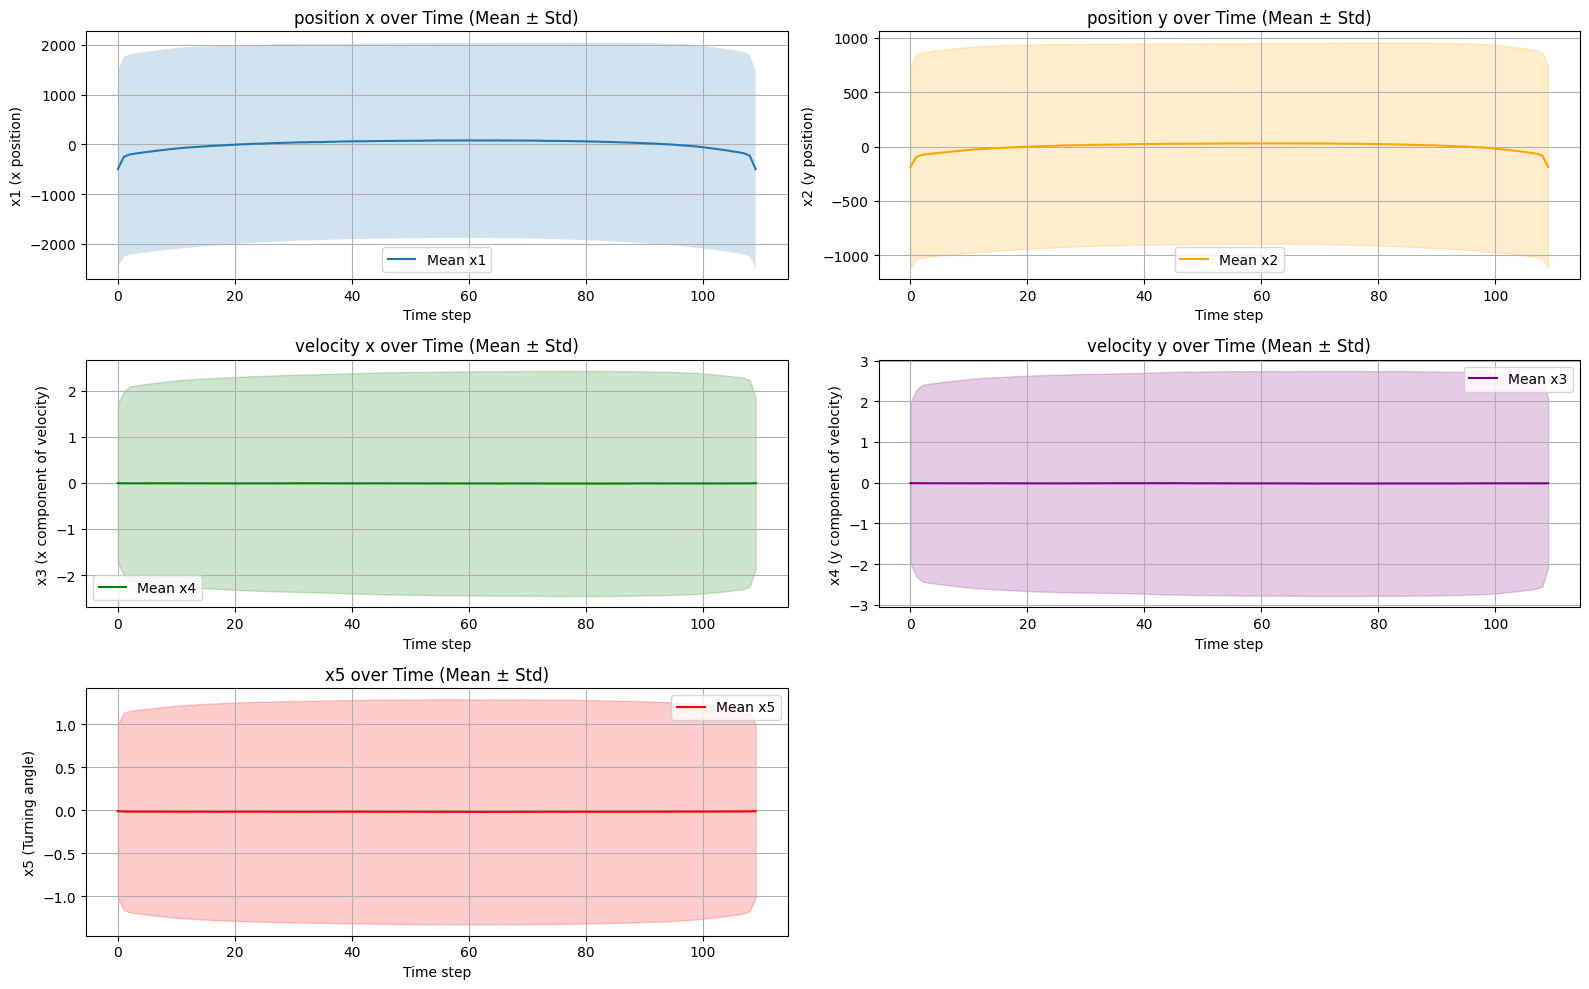

In [18]:
data = trainData
# Assuming data is already loaded and shaped correctly
samples, agents, timesteps, features = data.shape

# Reshape to aggregate across all (samples × agents)
flat_data = data.reshape(-1, timesteps, features)  # shape: (samples*agents, 110, 6)

# Compute mean and std
x1_mean = flat_data[:, :, 0].mean(axis=0)
x1_std = flat_data[:, :, 0].std(axis=0)

x2_mean = flat_data[:, :, 1].mean(axis=0)
x2_std = flat_data[:, :, 1].std(axis=0)

x3_mean = flat_data[:, :, 2].mean(axis=0)
x3_std = flat_data[:, :, 2].std(axis=0)

x4_mean = flat_data[:, :, 3].mean(axis=0)
x4_std = flat_data[:, :, 3].std(axis=0)

x5_mean = flat_data[:, :, 4].mean(axis=0)
x5_std = flat_data[:, :, 4].std(axis=0)

time = np.arange(timesteps)

# Set up figure with GridSpec: 2 rows (2x2 for time-series) + 1 full row for scatter
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2)

# Time-series subplots (2x2)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(time, x1_mean, label='Mean x1')
ax1.fill_between(time, x1_mean - x1_std, x1_mean + x1_std, alpha=0.2)
ax1.set_title("position x over Time (Mean ± Std)")
ax1.set_xlabel("Time step")
ax1.set_ylabel("x1 (x position)")
ax1.grid(True)
ax1.legend()

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(time, x2_mean, label='Mean x2', color='orange')
ax2.fill_between(time, x2_mean - x2_std, x2_mean + x2_std, alpha=0.2, color='orange')
ax2.set_title("position y over Time (Mean ± Std)")
ax2.set_xlabel("Time step")
ax2.set_ylabel("x2 (y position)")
ax2.grid(True)
ax2.legend()

ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(time, x4_mean, label='Mean x4', color='green')
ax3.fill_between(time, x4_mean - x4_std, x4_mean + x4_std, alpha=0.2, color='green')
ax3.set_title("velocity x over Time (Mean ± Std)")
ax3.set_xlabel("Time step")
ax3.set_ylabel("x3 (x component of velocity)")
ax3.grid(True)
ax3.legend()

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(time, x3_mean, label='Mean x3', color='purple')
ax4.fill_between(time, x3_mean - x3_std, x3_mean + x3_std, alpha=0.2, color='purple')
ax4.set_title("velocity y over Time (Mean ± Std)")
ax4.set_xlabel("Time step")
ax4.set_ylabel("x4 (y component of velocity)")
ax4.grid(True)
ax4.legend()


ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(time, x5_mean, label='Mean x5', color='red')
ax5.fill_between(time, x5_mean - x5_std, x5_mean + x5_std, alpha=0.2, color='red')
ax5.set_title("x5 over Time (Mean ± Std)")
ax5.set_xlabel("Time step")
ax5.set_ylabel("x5 (Turning angle)")
ax5.grid(True)
ax5.legend()


plt.tight_layout()
plt.show()


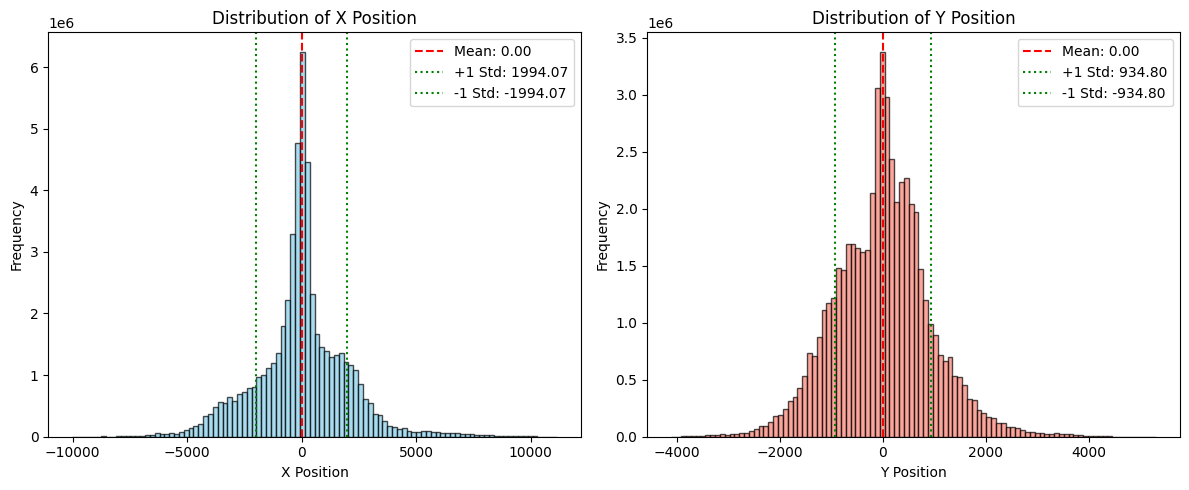

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten training data across all axes except feature
flat_data = trainData.reshape(-1, 6)

# Extract position x and y
x_positions = flat_data[:, 0]
y_positions = flat_data[:, 1]

# Compute mean and std
x_mean, x_std = x_positions.mean(), x_positions.std()
y_mean, y_std = y_positions.mean(), y_positions.std()

# Plot histograms
plt.figure(figsize=(12, 5))

# Position X
plt.subplot(1, 2, 1)
plt.hist(x_positions, bins=100, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(x_mean, color='r', linestyle='--', label=f'Mean: {x_mean:.2f}')
plt.axvline(x_mean + x_std, color='g', linestyle=':', label=f'+1 Std: {x_mean + x_std:.2f}')
plt.axvline(x_mean - x_std, color='g', linestyle=':', label=f'-1 Std: {x_mean - x_std:.2f}')
plt.title("Distribution of X Position")
plt.xlabel("X Position")
plt.ylabel("Frequency")
plt.legend()

# Position Y
plt.subplot(1, 2, 2)
plt.hist(y_positions, bins=100, alpha=0.7, color='salmon', edgecolor='k')
plt.axvline(y_mean, color='r', linestyle='--', label=f'Mean: {y_mean:.2f}')
plt.axvline(y_mean + y_std, color='g', linestyle=':', label=f'+1 Std: {y_mean + y_std:.2f}')
plt.axvline(y_mean - y_std, color='g', linestyle=':', label=f'-1 Std: {y_mean - y_std:.2f}')
plt.title("Distribution of Y Position")
plt.xlabel("Y Position")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


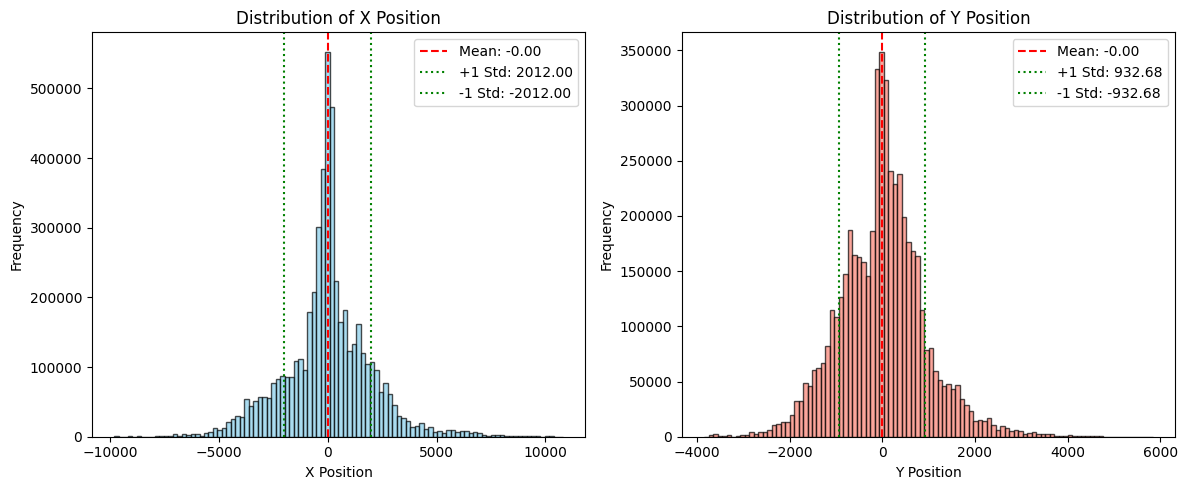

In [20]:

# Flatten training data across all axes except feature
flat_data = testData.reshape(-1, 6)

# Extract position x and y
x_positions = flat_data[:, 0]
y_positions = flat_data[:, 1]

# Compute mean and std
x_mean, x_std = x_positions.mean(), x_positions.std()
y_mean, y_std = y_positions.mean(), y_positions.std()

# Plot histograms
plt.figure(figsize=(12, 5))

# Position X
plt.subplot(1, 2, 1)
plt.hist(x_positions, bins=100, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(x_mean, color='r', linestyle='--', label=f'Mean: {x_mean:.2f}')
plt.axvline(x_mean + x_std, color='g', linestyle=':', label=f'+1 Std: {x_mean + x_std:.2f}')
plt.axvline(x_mean - x_std, color='g', linestyle=':', label=f'-1 Std: {x_mean - x_std:.2f}')
plt.title("Distribution of X Position")
plt.xlabel("X Position")
plt.ylabel("Frequency")
plt.legend()

# Position Y
plt.subplot(1, 2, 2)
plt.hist(y_positions, bins=100, alpha=0.7, color='salmon', edgecolor='k')
plt.axvline(y_mean, color='r', linestyle='--', label=f'Mean: {y_mean:.2f}')
plt.axvline(y_mean + y_std, color='g', linestyle=':', label=f'+1 Std: {y_mean + y_std:.2f}')
plt.axvline(y_mean - y_std, color='g', linestyle=':', label=f'-1 Std: {y_mean - y_std:.2f}')
plt.title("Distribution of Y Position")
plt.xlabel("Y Position")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


In [47]:
position_x = trainData[..., 0]  
position_y = trainData[..., 1]  
velocity_x = trainData[..., 2]  
velocity_y = trainData[..., 3]  

# Compute means
positionx_mean = np.mean(position_x)  
positiony_mean = np.mean(position_y)  
velocityx_mean = np.mean(velocity_x)  
velocityy_mean = np.mean(velocity_y)

# Compute mean and std for feature 0 (x) and 1 (y) across entire training set
positionx_std = np.std(position_x)
positiony_std = np.std(position_y)
velocityx_std = np.std(velocity_x)
velocityy_std = np.std(velocity_y)

print(positionx_mean, positionx_std, positiony_mean, positiony_std, velocityx_mean, velocityx_std)


# Define normalization function
def normalizeData(train, test, mean_x, std_x, mean_y, std_y, vlx_mean, vlx_std, vly_mean, vly_std):
    norm_train = train.copy()
    norm_test = test.copy()

    norm_train[..., 0] = (train[..., 0] - mean_x) / std_x
    norm_train[..., 1] = (train[..., 1] - mean_y) / std_y
    norm_train[..., 2] = (train[..., 2] - vlx_mean) / vlx_std
    norm_train[..., 3] = (train[..., 3] - vly_mean) / vly_std

    norm_test[..., 0] = (test[..., 0] - mean_x) / std_x
    norm_test[..., 1] = (test[..., 1] - mean_y) / std_y
    norm_test[..., 2] = (test[..., 2] - vlx_mean) / vlx_std
    norm_test[..., 3] = (test[..., 3] - vly_mean) / vly_std

    return norm_train, norm_test

# Normalize the data
normalizedtrain, normalizedtest = normalizeData(trainData, testData,
                                                positionx_mean, positionx_std,
                                                positiony_mean, positiony_std,
                                                velocityx_mean, velocityx_std,
                                                velocityy_mean, velocityy_std)
normalizedtrain.shape, normalizedtest.shape

3.5178593613884666e-15 1994.0700453783013 2.497637813741511e-16 934.802124509779 -0.017081284552795496 2.6829236458902184


((10000, 50, 110, 6), (2100, 50, 50, 6))

In [48]:
print(positionx_mean, positionx_std, positiony_mean, positiony_std, velocityx_mean, velocityx_std)


3.5178593613884666e-15 1994.0700453783013 2.497637813741511e-16 934.802124509779 -0.017081284552795496 2.6829236458902184


In [49]:
# make_gif(normalizedtrain[0], 'index_0_norm')

In [50]:
training_data = normalizedtrain[:9000]
validation_data = normalizedtrain[9000:]
training_data.shape, validation_data.shape

((9000, 50, 110, 6), (1000, 50, 110, 6))

In [51]:
class WindowedNormalizedDataset(Dataset):
    def __init__(self, data, window_size, forecast_horizon):
        self.data = data
        self.window_size = window_size
        self.forecast_horizon = forecast_horizon

        self.indices = []
        for sample in range(data.shape[0]):
            for t in range(data.shape[2] - window_size - forecast_horizon + 1):
                self.indices.append((sample, t))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample_idx, t = self.indices[idx]

        x = self.data[sample_idx, :, t:t+self.window_size, :]
        y = self.data[sample_idx, 0, t+self.window_size:t+self.window_size+self.forecast_horizon, :2]
        # print(x.shape, y.shape)

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [52]:
train_dataset = WindowedNormalizedDataset(data = training_data, window_size=50, forecast_horizon=60)
validation_dataset = WindowedNormalizedDataset(data = validation_data, window_size=50, forecast_horizon=60)

In [53]:
class EncoderDecoderModel(nn.Module):
    def __init__(self, infeatures, outfeatures=2):
        super().__init__()
        # Encoder
        self.layer1 = nn.Linear(infeatures, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 128)
        self.encoderlstm = nn.LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
        
        # Changed pooling target from 20 to 60
        self.pool = nn.AdaptiveAvgPool1d(60)
        self.dropout = nn.Dropout(0.2)
        
        # Decoder
        self.decoderlstm = nn.LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.3)
        self.layer10 = nn.Linear(128, 64)
        self.layer11 = nn.Linear(64, 32)
        self.layer12 = nn.Linear(32, outfeatures)
        
        # Skip connections
        self.skip1 = nn.Linear(32, 32)
        self.skip2 = nn.Linear(64, 64)
        self.skip3 = nn.Linear(128, 128)
        self.skip4 = nn.Linear(256, 256)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        
        # Encoder
        out1 = nn.ReLU()(self.layer1(x))
        out2 = nn.ReLU()(self.layer2(out1))
        out3 = nn.ReLU()(self.layer3(out2))
        
        # LSTM processing
        tempout3 = out3.view(batch_size, -1, out3.size(-1))
        out4, _ = self.encoderlstm(tempout3)
        
        # Changed pooling to 60
        tempout4 = self.pool(out4.permute(0, 2, 1))
        tempout4 = tempout4.permute(0, 2, 1)
        lstmskip = tempout4 + self.skip4(tempout4)
        
        # Decoder LSTM
        out5, _ = self.decoderlstm(lstmskip)
        
        out3_reduced = F.adaptive_avg_pool2d(out3.permute(0, 3, 1, 2), (60, 1)).squeeze(-1).permute(0, 2, 1)
        mlpskip1 = out3_reduced + self.skip3(out5)
        out6 = nn.ReLU()(self.layer10(mlpskip1))
        
        out2_reduced = F.adaptive_avg_pool2d(out2.permute(0, 3, 1, 2), (60, 1)).squeeze(-1).permute(0, 2, 1)
        mlpskip2 = out2_reduced + self.skip2(out6)
        out7 = nn.ReLU()(self.layer11(mlpskip2))
        
        out1_reduced = F.adaptive_avg_pool2d(out1.permute(0, 3, 1, 2), (60, 1)).squeeze(-1).permute(0, 2, 1)
        mlpskip3 = out1_reduced + self.skip1(out7)
        out8 = self.layer12(mlpskip3)
        
        return out8

# Verify the output shape
def xavier_init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
        
model = EncoderDecoderModel(6, 2)
model.apply(xavier_init_weights)

# test = torch.randn(128, 50, 50, 6)
# out = model(test)
# print(out.shape)  # Should output torch.Size([128, 60, 2])
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 1359906


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# model.load_state_dict(torch.load("./models/modelF/medium_model_0.0062230645.pth"))  

trainDataLoader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
testDataLoader = DataLoader(validation_dataset, batch_size=128)
model.to(device)
# print(len(trainDataLoader))
# Training setup
epochs = 1000
lossFn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

minLoss = 99999999
# Iused 0.0008, 0.0001

for each_epoch in range(epochs):
    model.train()
    runningLoss = 0.0
    loop = tqdm(trainDataLoader, desc=f"Epoch [{each_epoch+1}/{epochs}]")
    for batchX, batchY in loop:
        batchX, batchY = batchX.to(device, non_blocking=True), batchY.to(device, non_blocking=True)
        output = model(batchX)
        # print("Pred Training Shape: ", output.shape,"True Value", batchY.shape)
        # break
        loss = lossFn(output, batchY)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        runningLoss += loss.item() * batchX.size(0)

    avgLoss = runningLoss / len(trainDataLoader.dataset)
    # print(epoch_loss)    
    # break

    model.eval()
    with torch.inference_mode():
        testloss = 0.0
        for testX, testY in testDataLoader:
            testX, testY = testX.to(device, non_blocking=True), testY.to(device, non_blocking=True)
            pred = model(testX)
            tloss = lossFn(pred, testY)
            testloss += tloss.item() * testX.size(0)

        avgtestloss = testloss / len(testDataLoader.dataset)
    
        
    print(f"Epoch {each_epoch + 1}, Training Loss: {avgLoss:.10f} and Validation Loss:{avgtestloss}")
    # break
    if(avgLoss < minLoss):
        minLoss = avgLoss
        torch.save(model.state_dict(), f'./models/modelI/medium_model_{avgLoss:.10f}.pth')
        
    with open("./models/modelI/log_loss.txt", 'a') as f:
        f.write(f"{each_epoch + 1},{avgLoss:.10f},{avgtestloss:.10f},\n")
        
    torch.cuda.empty_cache()
    scheduler.step()


Epoch [1/1000]:   0%|          | 0/71 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [37]:
def createSubmission(modelPath, submissionFileName, testmeanX, testmeanY, positionx_mean, positionx_std, positiony_mean, positiony_std):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(modelPath, map_location=device))  
    test_data = torch.tensor(normalizedtest, dtype=torch.float32)
    testmeanX = torch.Tensor(testmeanX)
    testmeanY = torch.Tensor(testmeanY)
    rows = []
    for i in range(test_data.shape[0]):
        pred = model(test_data[i].unsqueeze(0))
        pred[:, :, 0] = (pred[:, :, 0]  * positionx_std) + positionx_mean
        pred[:, :, 1] = (pred[:, :, 1]  * positiony_std) + positiony_mean
        pred[..., 0] += testmeanX[i]
        pred[..., 1] += testmeanY[i]

        # print(pred.shape, pred)
        # break
        items = pred.squeeze(0).tolist()
        for idx, (x, y) in enumerate(items):
            rows.append({'x': x, 'y': y})

    df = pd.DataFrame(rows)
    df.index.name = 'index'
    df.to_csv('./submission/'+submissionFileName)


createSubmission("./models/medium_model_0.0060316141.pth", "test23.csv", testmeanX, testmeanY, positionx_mean, positionx_std, positiony_mean, positiony_std)